### Modelling LLM and KMeans Hybrid Approach

#### Importing Libriaries

In [310]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [312]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import plotly.express as px
from sentence_transformers import SentenceTransformer
from kmodes.kprototypes import KPrototypes
from kneed import KneeLocator
import gower

In [314]:
df = pd.read_csv("../data/customer_segmentation_data.csv")
df.drop(['id'],axis=1,inplace=True)

In [316]:
df.head()

,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount
0,38,Female,99342,90,3,24,Groceries,113.53
1,21,Female,78852,60,2,42,Sports,41.93
2,60,Female,126573,30,2,28,Clothing,424.36
3,40,Other,47099,74,9,5,Home & Garden,991.93
4,65,Female,140621,21,3,25,Electronics,347.08


In [318]:
sns.set_style('whitegrid')
sns.set_palette('RdBu_r')
custom_palette = sns.color_palette('RdBu_r', n_colors=10)

In [320]:
df['gender'] = df['gender'].astype('category')
df['preferred_category'] = df['preferred_category'].astype('category')

In [332]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   age                   1000 non-null   int64   
 1   gender                1000 non-null   category
 2   income                1000 non-null   int64   
 3   spending_score        1000 non-null   int64   
 4   membership_years      1000 non-null   int64   
 5   purchase_frequency    1000 non-null   int64   
 6   preferred_category    1000 non-null   category
 7   last_purchase_amount  1000 non-null   float64 
dtypes: category(2), float64(1), int64(5)
memory usage: 49.3 KB


In [328]:
scaler = StandardScaler() 
df_clean = pd.read_csv("../data/customer_segmentation_data.csv")
df_clean.drop(['id'],axis=1,inplace=True)
df_clean[['Scaledage','Scaledincome','Scaledspending_score','Scaledpurchase_frequency','Scaledlast_purchase_amount','Scaledmembership_years']] = scaler.fit_transform(df_clean[['age','income','spending_score','purchase_frequency','last_purchase_amount','membership_years']]) 
df_clean.drop(['age','income','spending_score','purchase_frequency','last_purchase_amount','membership_years'], inplace=True, axis=1)

In [340]:
df_clean['gender'] = df_clean['gender'].astype('category')
df_clean['preferred_category'] = df_clean['preferred_category'].astype('category')

In [342]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   gender                      1000 non-null   category
 1   preferred_category          1000 non-null   category
 2   Scaledage                   1000 non-null   float64 
 3   Scaledincome                1000 non-null   float64 
 4   Scaledspending_score        1000 non-null   float64 
 5   Scaledpurchase_frequency    1000 non-null   float64 
 6   Scaledlast_purchase_amount  1000 non-null   float64 
 7   Scaledmembership_years      1000 non-null   float64 
dtypes: category(2), float64(6)
memory usage: 49.3 KB


In [344]:
categorical_columns = [0,1]
distortions = []

k_range = range(2, 9)
for k in k_range:
    kp = KPrototypes(n_clusters=k,random_state=42)
    kp.fit(df_clean, categorical=categorical_columns)
    distortion = kp.cost_
    distortions.append(distortion)

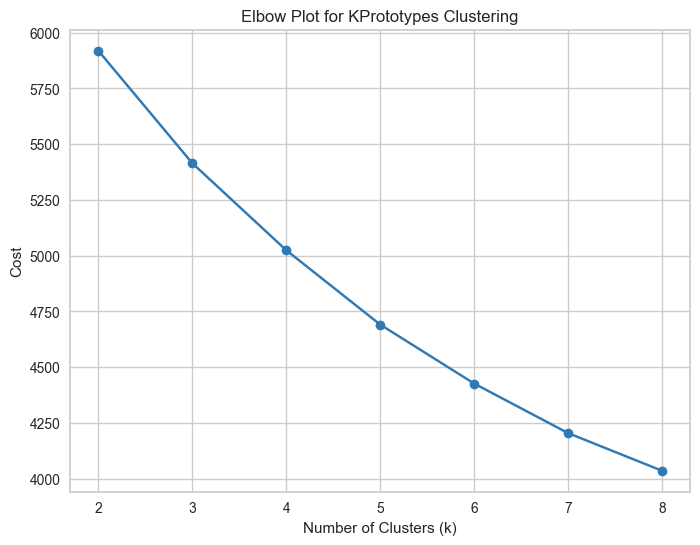

In [345]:
plt.figure(figsize=(8, 6))
plt.plot(k_range, distortions, marker='o')
plt.title('Elbow Plot for KPrototypes Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Cost')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [346]:
cost_knee_c3 = KneeLocator(
        x=list(k_range), 
        y=list(distortions), 
        S=0.1, curve="convex", direction="decreasing", online=True)

K_cost_c3 = cost_knee_c3.elbow   
print("elbow at k =", f'{K_cost_c3:.0f} clusters')

elbow at k = 5 clusters


In [350]:
df_cleaned = pd.get_dummies(data=df_clean,columns=['gender','preferred_category'],drop_first=True)

In [352]:
df_cleaned

,Scaledage,Scaledincome,Scaledspending_score,Scaledpurchase_frequency,Scaledlast_purchase_amount,Scaledmembership_years,gender_Male,gender_Other,preferred_category_Electronics,preferred_category_Groceries,preferred_category_Home & Garden,preferred_category_Sports
0,-0.384644,0.316868,1.358468,-0.182348,-1.281540,-0.865010,False,False,False,True,False,False
1,-1.515362,-0.282016,0.321865,1.082005,-1.523763,-1.215358,False,False,False,False,False,True
2,1.078639,1.112778,-0.714738,0.098620,-0.230005,-1.215358,False,False,False,False,False,False
3,-0.251618,-1.210096,0.805613,-1.516943,1.690080,1.237080,False,True,False,False,True,False
4,1.411203,1.523374,-1.025718,-0.112106,-0.491443,-0.865010,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.879100,0.691806,0.218205,-1.797910,-0.604570,0.186035,True,False,False,False,False,False
996,-1.382336,-0.677034,0.874720,-0.252590,0.475247,1.587428,False,True,False,True,False,False
997,-1.382336,0.718900,-0.369203,1.082005,-1.411583,-0.164313,True,False,False,False,False,True
998,-1.448849,0.736379,0.425525,1.222489,0.043341,0.536383,False,False,True,False,False,False


In [354]:
distance_matrix = gower.gower_matrix(df_cleaned)
dist = pd.DataFrame(distance_matrix)
dist

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000000,0.279832,0.230945,0.464882,0.318911,0.358645,0.304922,0.213932,0.498240,0.395128,...,0.374030,0.421772,0.292351,0.344704,0.386415,0.318150,0.253505,0.378521,0.329546,0.147305
1,0.279832,0.000000,0.261482,0.522646,0.378171,0.345061,0.235805,0.483560,0.365769,0.429323,...,0.181161,0.285147,0.292519,0.349487,0.347670,0.380810,0.432283,0.157795,0.283745,0.315373
2,0.230945,0.261482,0.000000,0.443326,0.129708,0.308307,0.305386,0.353782,0.360126,0.292565,...,0.296650,0.371062,0.250141,0.275811,0.193301,0.213249,0.408518,0.325909,0.262461,0.192752
3,0.464882,0.522646,0.443326,0.000000,0.544311,0.238191,0.296778,0.456547,0.435825,0.329381,...,0.375433,0.352480,0.299954,0.370129,0.465925,0.429001,0.278915,0.612763,0.460776,0.479236
4,0.318911,0.378171,0.129708,0.544311,0.000000,0.396377,0.403557,0.461570,0.459428,0.226884,...,0.401037,0.482252,0.344910,0.210129,0.314591,0.301215,0.509503,0.424080,0.206984,0.307309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.318150,0.380810,0.213249,0.429001,0.301215,0.454572,0.369159,0.247621,0.231392,0.271404,...,0.417728,0.453488,0.310484,0.352876,0.219874,0.000000,0.455418,0.252923,0.328487,0.376188
996,0.253505,0.432283,0.408518,0.278915,0.509503,0.351797,0.221722,0.268843,0.534496,0.412865,...,0.285070,0.362191,0.376257,0.370066,0.490777,0.455418,0.000000,0.522400,0.370413,0.270827
997,0.378521,0.157795,0.325909,0.612763,0.424080,0.438545,0.332458,0.366357,0.255549,0.511023,...,0.262384,0.368698,0.333279,0.409301,0.293005,0.252923,0.522400,0.000000,0.329555,0.411305
998,0.329546,0.283745,0.262461,0.460776,0.206984,0.432785,0.263642,0.381037,0.494135,0.205837,...,0.355659,0.413612,0.248852,0.163038,0.383443,0.328487,0.370413,0.329555,0.000000,0.335075


In [356]:
range_n_clusters = [2,3,4,5,6,7,8]
cat_cols = [0,1]
silhouette_avg = []
for num_clusters in range_n_clusters:
    kprot = KPrototypes(n_clusters=num_clusters, random_state=42)
    kprot.fit(df_clean,categorical=cat_cols)
    cluster_labels = kprot.labels_

    silhouette_avg.append(silhouette_score(dist, cluster_labels, metric='precomputed'))

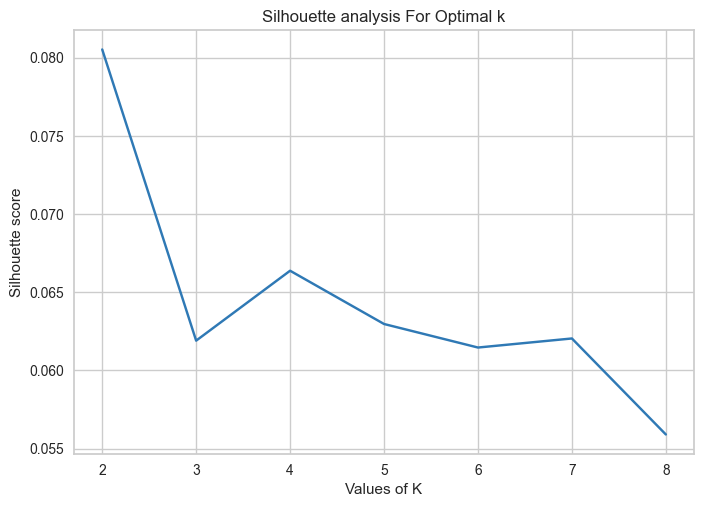

In [357]:
plt.plot(range_n_clusters, silhouette_avg)
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()

In [448]:
silhouette_avg.sort
silhouette_avg

[0.08052262,
 0.06190672,
 0.06637672,
 0.062971376,
 0.061466392,
 0.062045895,
 0.055908043]

In [382]:
kprot = KPrototypes(n_clusters=5, random_state=42)
kprot.fit(df_clean, categorical=[0,1])
cluster_labels = kprot.labels_
clusters = pd.DataFrame(cluster_labels, columns=['cluster'])
clusters.head()

,cluster
0,0
1,0
2,4
3,3
4,4


In [446]:
df_seg = pd.concat([df_cleaned,clusters], axis=1)
df_seg

,Scaledage,Scaledincome,Scaledspending_score,Scaledpurchase_frequency,Scaledlast_purchase_amount,Scaledmembership_years,gender_Male,gender_Other,preferred_category_Electronics,preferred_category_Groceries,preferred_category_Home & Garden,preferred_category_Sports,cluster
0,-0.384644,0.316868,1.358468,-0.182348,-1.281540,-0.865010,False,False,False,True,False,False,0
1,-1.515362,-0.282016,0.321865,1.082005,-1.523763,-1.215358,False,False,False,False,False,True,0
2,1.078639,1.112778,-0.714738,0.098620,-0.230005,-1.215358,False,False,False,False,False,False,4
3,-0.251618,-1.210096,0.805613,-1.516943,1.690080,1.237080,False,True,False,False,True,False,3
4,1.411203,1.523374,-1.025718,-0.112106,-0.491443,-0.865010,False,False,True,False,False,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.879100,0.691806,0.218205,-1.797910,-0.604570,0.186035,True,False,False,False,False,False,4
996,-1.382336,-0.677034,0.874720,-0.252590,0.475247,1.587428,False,True,False,True,False,False,3
997,-1.382336,0.718900,-0.369203,1.082005,-1.411583,-0.164313,True,False,False,False,False,True,0
998,-1.448849,0.736379,0.425525,1.222489,0.043341,0.536383,False,False,True,False,False,False,0


In [390]:
pca = PCA(n_components=3, random_state=42)
pca_components = pca.fit_transform(df_seg.drop('cluster',axis=1))

In [392]:
df_seg['PCA_1'] = pca_components[:,0]
df_seg['PCA_2'] = pca_components[:,1]
df_seg['PCA_3'] = pca_components[:,2]

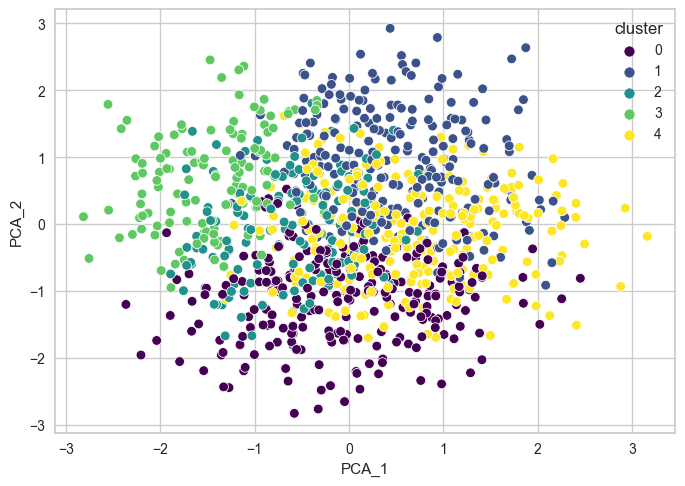

In [394]:
aa = sns.scatterplot(data=df_seg, x='PCA_1', y='PCA_2', hue='cluster', palette='viridis');

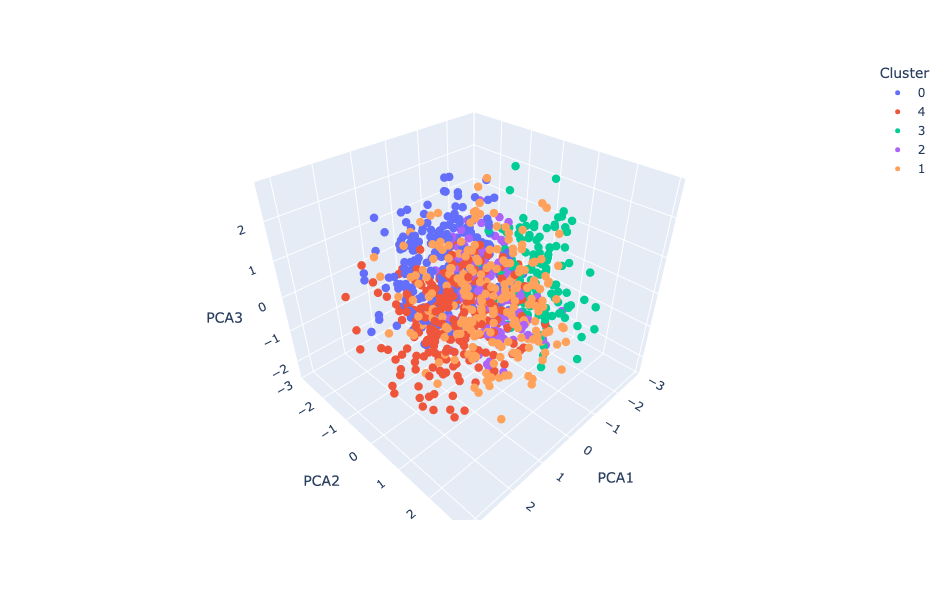

In [396]:
fig = px.scatter_3d(x=df_seg['PCA_1'],y=df_seg['PCA_2'],z=df_seg['PCA_3'],
                    color=df_seg['cluster'].astype(str),
                    labels={
                        'x':'PCA1',
                        'y':'PCA2',
                        'z':'PCA3'
                    },
                    template='plotly')
fig.update_layout(width=800,
                  height=600,
                  legend_title_text='Cluster')


fig.update_traces(marker=dict(size=5))
fig.show()

In [398]:
explained_variance_ratio = pca.explained_variance_ratio_
for indx, evr in enumerate(explained_variance_ratio):
    print(f"PC{indx+1}: {evr:.2f}")

PC1: 0.15
PC2: 0.15
PC3: 0.14


In [400]:
pca_results = pd.concat([pd.DataFrame(pca.explained_variance_,columns=['EigenValue']),pd.DataFrame(pca.explained_variance_ratio_,columns=['% of Variance'])],axis=1)
pca_results['% of variance (Cum)'] = pca_results['% of Variance'].cumsum()*100
pca_results

,EigenValue,% of Variance,% of variance (Cum)
0,1.091704,0.153450,15.345044
1,1.085047,0.152515,30.596525
2,1.020613,0.143458,44.942318


In [402]:
df_analysis = pd.concat([df,clusters], axis=1)

In [404]:
df_analysis

,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount,cluster
0,38,Female,99342,90,3,24,Groceries,113.53,0
1,21,Female,78852,60,2,42,Sports,41.93,0
2,60,Female,126573,30,2,28,Clothing,424.36,4
3,40,Other,47099,74,9,5,Home & Garden,991.93,3
4,65,Female,140621,21,3,25,Electronics,347.08,4
...,...,...,...,...,...,...,...,...,...
995,57,Male,112170,57,6,1,Clothing,313.64,4
996,23,Other,65337,76,10,23,Groceries,632.83,3
997,23,Male,113097,40,5,42,Sports,75.09,0
998,22,Female,113695,63,7,44,Electronics,505.16,0


In [442]:
df_group = df_analysis.groupby('cluster').agg(
    {
        'age': 'mean',
        'gender': lambda x: x.value_counts().index[0],
        'income': 'mean',
        'spending_score': 'mean',
        'membership_years': 'mean',
        'purchase_frequency':'mean',
        'preferred_category': lambda x: ', '.join(x.value_counts().index[[0,1,2]]),
        'last_purchase_amount': 'mean',
        
    }
)
df_group

,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount
cluster,,,,,,,,
0,29.468254,Female,83582.257937,56.154762,5.369048,30.337302,"Sports, Home & Garden, Groceries",265.192024
1,43.392241,Other,81894.793103,43.918103,3.012931,20.758621,"Electronics, Home & Garden, Sports",756.988664
2,45.120567,Male,120035.042553,56.375887,7.829787,31.914894,"Home & Garden, Groceries, Sports",713.944610
3,49.092308,Male,58929.661538,55.438462,7.661538,36.038462,"Electronics, Groceries, Sports",710.363769
4,55.289796,Other,97357.885714,45.669388,5.375510,20.204082,"Electronics, Groceries, Sports",232.185429


In [408]:
cluster_summary = df_analysis.groupby('cluster').agg({
    'age': ['min','mean','max'],
    'income': ['min','mean','max'],
    'spending_score': ['min','mean','max'],
    'purchase_frequency': ['min','mean','max'],
    'last_purchase_amount': ['min','mean','max']
})
cluster_summary

age                income                        spending_score  \
        min       mean max    min           mean     max            min   
cluster                                                                   
0        18  29.468254  53  30074   83582.257937  148451              1   
1        18  43.392241  69  30102   81894.793103  149973              1   
2        18  45.120567  69  79992  120035.042553  149936              2   
3        19  49.092308  69  30004   58929.661538   97989              1   
4        27  55.289796  69  30738   97357.885714  149744              1   

                        purchase_frequency                 \
              mean  max                min       mean max   
cluster                                                     
0        56.154762  100                  1  30.337302  50   
1        43.918103  100                  1  20.758621  50   
2        56.375887  100                  5  31.914894  50   
3        55.438462  100                  3  36.038462  50   
4        45.669388  100                  1  20.204082  50   

        last_purchase_amount                      
                         min        mean     max  
cluster                                           
0                      13.69  265.192024  696.90  
1                     371.77  756.988664  998.51  
2                     171.38  713.944610  999.74  
3                     170.56  710.363769  991.93  
4                      10.40  232.185429  714.72

In [410]:
cluster_distribution = df_analysis['cluster'].value_counts()
print(cluster_distribution)

cluster
0    252
4    245
1    232
2    141
3    130
Name: count, dtype: int64


In [412]:
pref_category_summary = df_analysis.groupby(['cluster', 'preferred_category']).size().unstack(fill_value=0)
pref_category_summary

preferred_category,Clothing,Electronics,Groceries,Home & Garden,Sports
cluster,,,,,
0,40,45,49,54,64
1,40,56,42,50,44
2,23,23,32,35,28
3,24,32,25,24,25
4,43,59,51,43,49


In [414]:
pref_category_proportions = pref_category_summary.div(pref_category_summary.sum(axis=1), axis=0)
pref_category_proportions

preferred_category,Clothing,Electronics,Groceries,Home & Garden,Sports
cluster,,,,,
0,0.158730,0.178571,0.194444,0.214286,0.253968
1,0.172414,0.241379,0.181034,0.215517,0.189655
2,0.163121,0.163121,0.226950,0.248227,0.198582
3,0.184615,0.246154,0.192308,0.184615,0.192308
4,0.175510,0.240816,0.208163,0.175510,0.200000


In [416]:
gen_category_summary = df_analysis.groupby(['cluster', 'gender']).size().unstack(fill_value=0)
gen_category_summary

gender,Female,Male,Other
cluster,,,
0,102,93,57
1,65,75,92
2,40,55,46
3,27,59,44
4,82,75,88


In [418]:
gen_category_proportions = gen_category_summary.div(gen_category_summary.sum(axis=1), axis=0)
gen_category_proportions

gender,Female,Male,Other
cluster,,,
0,0.404762,0.369048,0.226190
1,0.280172,0.323276,0.396552
2,0.283688,0.390071,0.326241
3,0.207692,0.453846,0.338462
4,0.334694,0.306122,0.359184


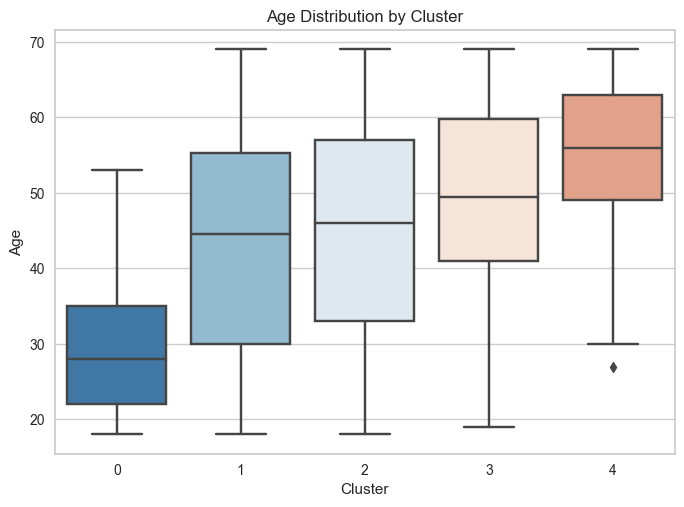

In [420]:
a = sns.boxplot(data=df_analysis, x='cluster', y='age')
a.set(xlabel='Cluster', ylabel='Age', title='Age Distribution by Cluster');

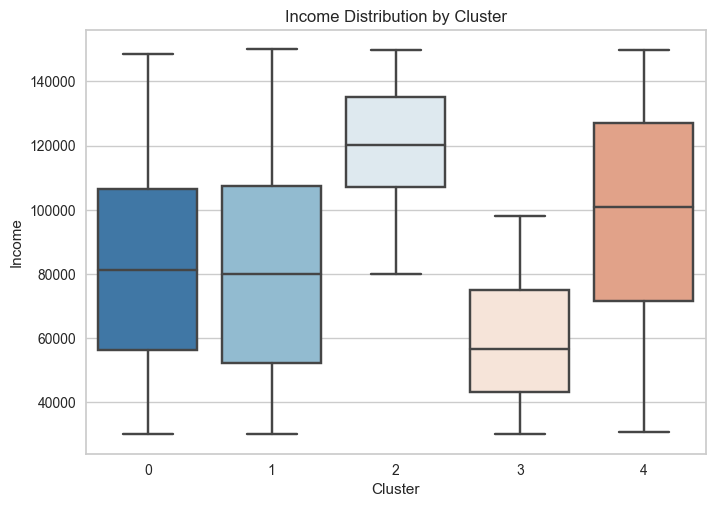

In [422]:
b = sns.boxplot(data=df_analysis, x='cluster', y='income')
b.set(xlabel='Cluster', ylabel='Income', title='Income Distribution by Cluster');

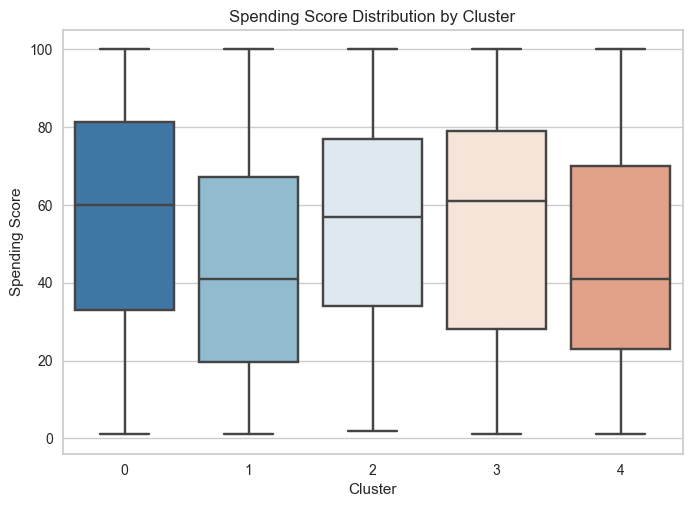

In [424]:
c = sns.boxplot(data=df_analysis, x='cluster', y='spending_score')
c.set(xlabel='Cluster', ylabel='Spending Score', title='Spending Score Distribution by Cluster');

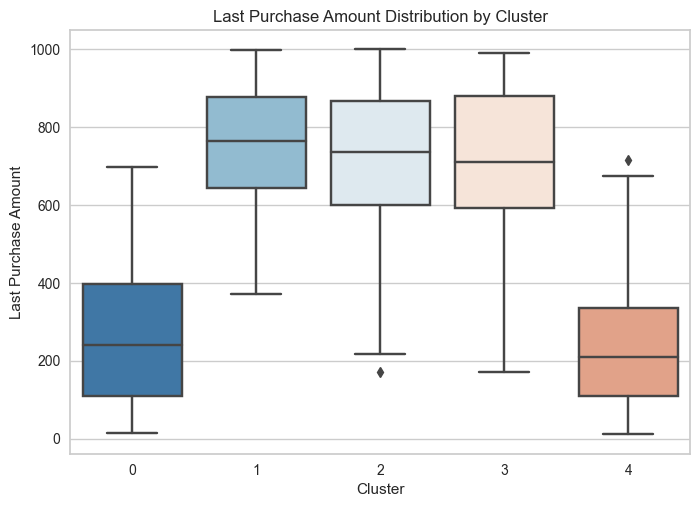

In [426]:
d = sns.boxplot(data=df_analysis, x='cluster', y='last_purchase_amount')
d.set(ylabel='Last Purchase Amount', xlabel='Cluster', title='Last Purchase Amount Distribution by Cluster');

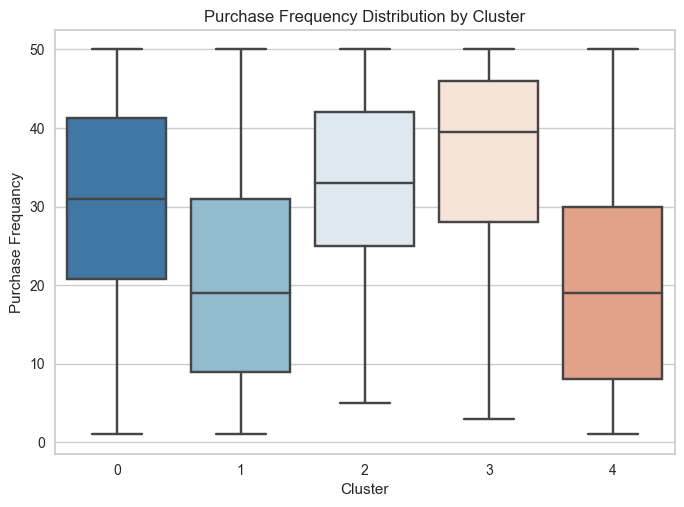

In [428]:
e = sns.boxplot(data=df_analysis, x='cluster', y='purchase_frequency')
e.set(xlabel='Cluster', ylabel='Purchase Frequancy', title='Purchase Frequency Distribution by Cluster');

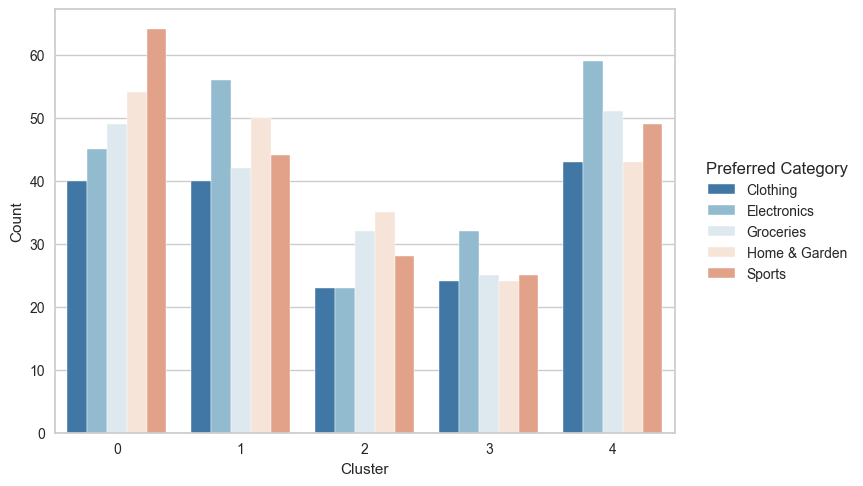

In [430]:
f = sns.countplot(data=df_analysis, hue='preferred_category', x='cluster')
f.set(xlabel = 'Cluster', ylabel='Count')
f.legend(title='Preferred Category', loc='center right', bbox_to_anchor=(1.3, 0.5));

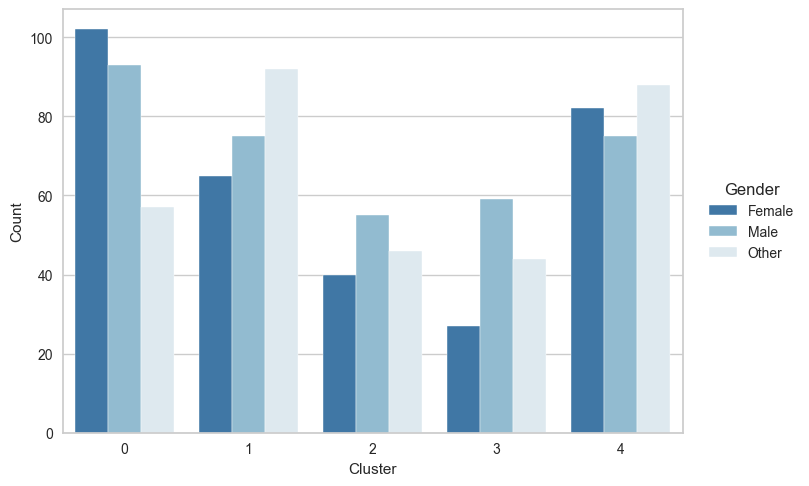

In [432]:
g = sns.countplot(data=df_analysis, hue='gender', x='cluster')
g.set(xlabel = 'Cluster', ylabel='Count')
g.legend(title='Gender', loc='center right', bbox_to_anchor=(1.2, 0.5));

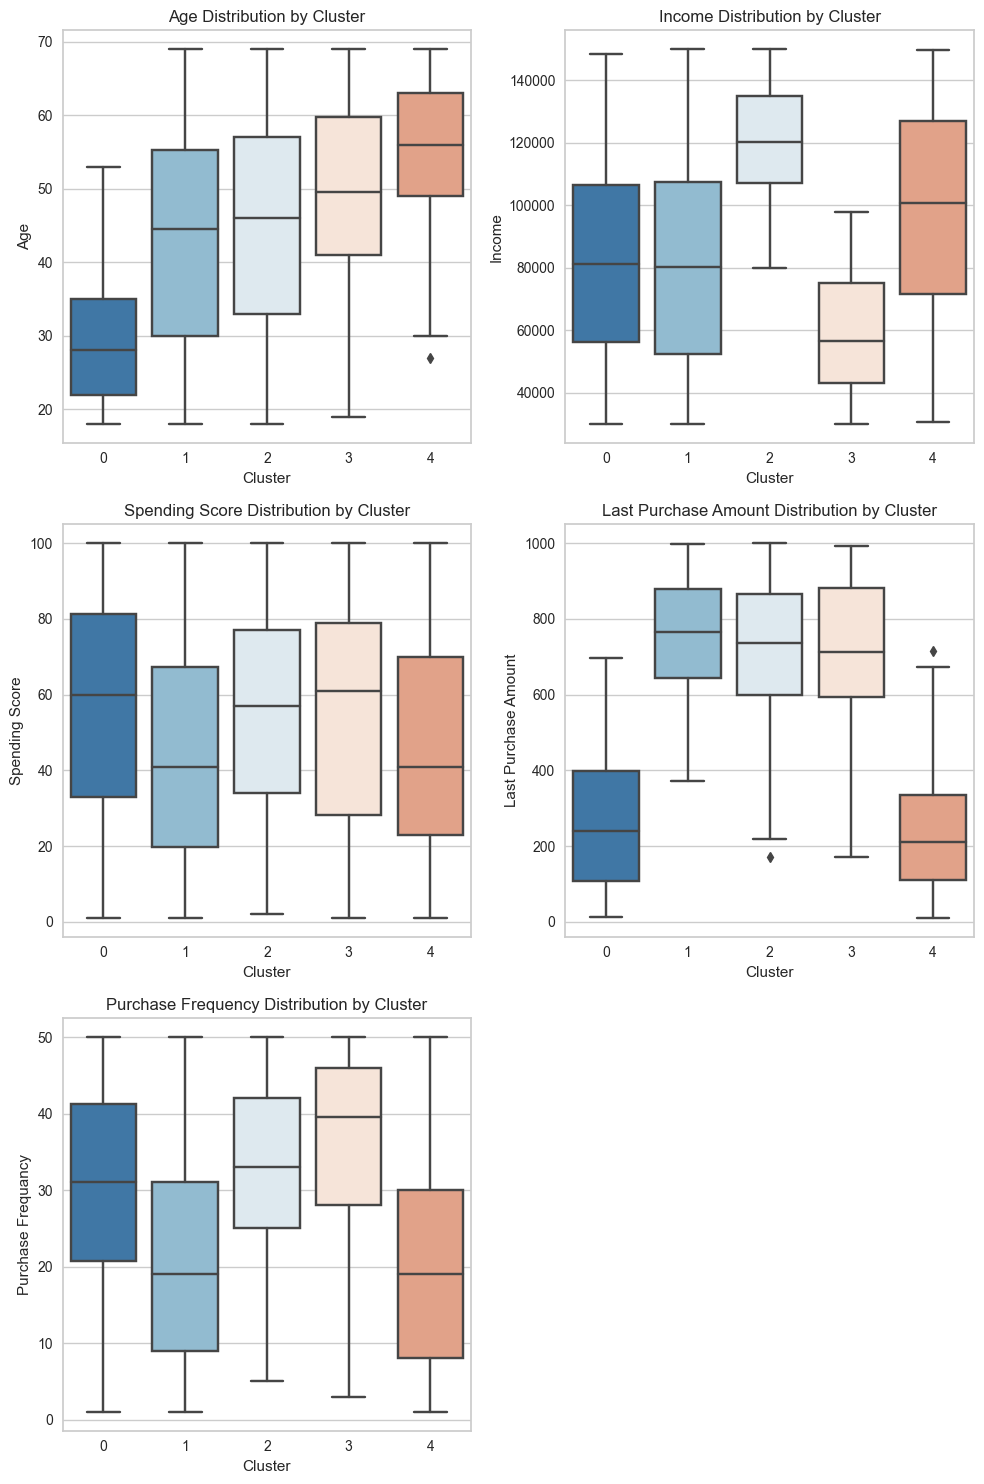

In [434]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
axes = axes.flatten() 

a = sns.boxplot(data=df_analysis, x='cluster', y='age', ax=axes[0])
a.set(xlabel='Cluster', ylabel='Age', title='Age Distribution by Cluster')
b = sns.boxplot(data=df_analysis, x='cluster', y='income', ax=axes[1])
b.set(xlabel='Cluster', ylabel='Income', title='Income Distribution by Cluster')
c = sns.boxplot(data=df_analysis, x='cluster', y='spending_score', ax=axes[2])
c.set(xlabel='Cluster', ylabel='Spending Score', title='Spending Score Distribution by Cluster')
d = sns.boxplot(data=df_analysis, x='cluster', y='last_purchase_amount', ax=axes[3])
d.set(ylabel='Last Purchase Amount', xlabel='Cluster', title='Last Purchase Amount Distribution by Cluster')
e = sns.boxplot(data=df_analysis, x='cluster', y='purchase_frequency', ax=axes[4])
e.set(xlabel='Cluster', ylabel='Purchase Frequancy', title='Purchase Frequency Distribution by Cluster')

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

In [436]:
df_group

,age,gender,income,spending_score,membership_years,purchase_frequency,preferred_category,last_purchase_amount
cluster,,,,,,,,
0,29.468254,Female,83582.257937,56.154762,5.369048,30.337302,Sports,265.192024
1,43.392241,Other,81894.793103,43.918103,3.012931,20.758621,Electronics,756.988664
2,45.120567,Male,120035.042553,56.375887,7.829787,31.914894,Home & Garden,713.944610
3,49.092308,Male,58929.661538,55.438462,7.661538,36.038462,Electronics,710.363769
4,55.289796,Other,97357.885714,45.669388,5.375510,20.204082,Electronics,232.185429


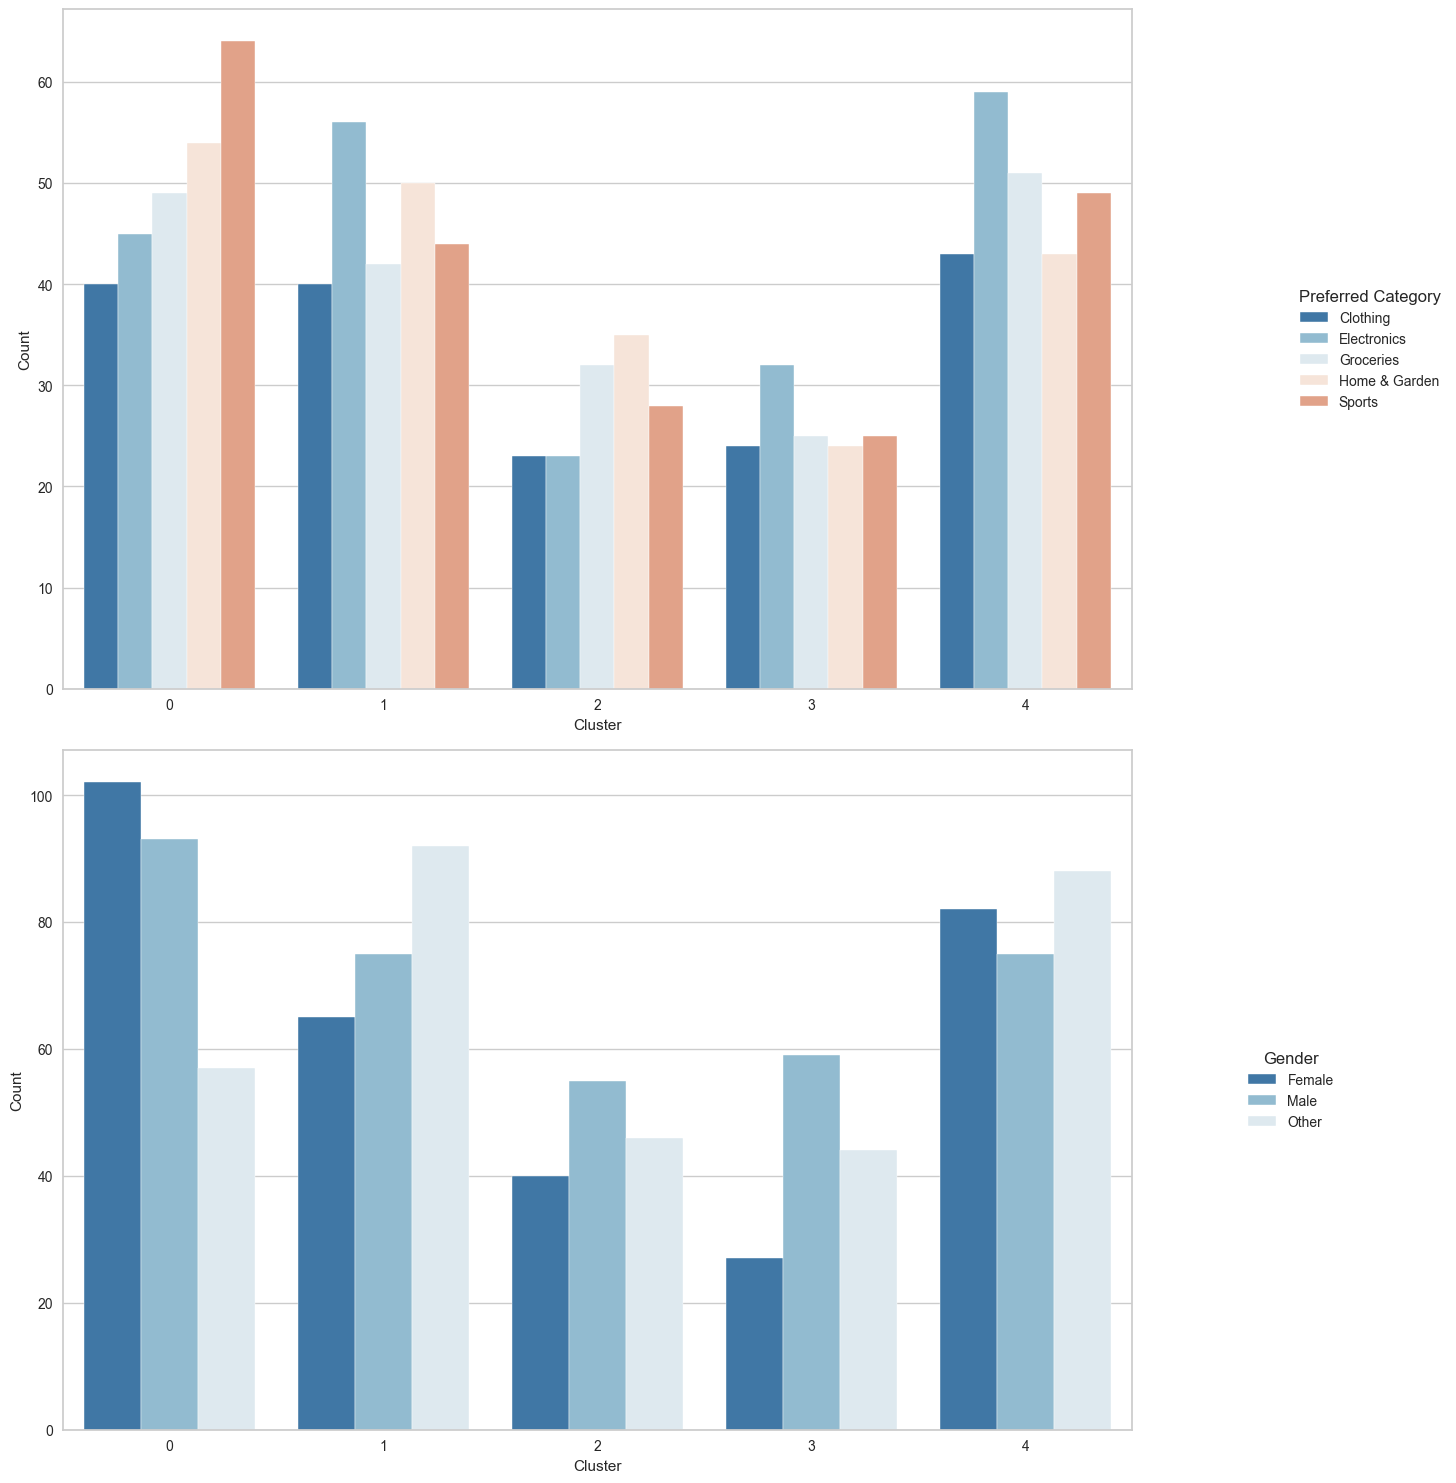

In [438]:
fig1, axes1 = plt.subplots(2, 1, figsize=(15, 15))
axes1 = axes1.flatten() 

f = sns.countplot(data=df_analysis, hue='preferred_category', x='cluster', ax=axes1[0])
f.set(xlabel = 'Cluster', ylabel='Count')
f.legend(title='Preferred Category', loc='center right', bbox_to_anchor=(1.3, 0.5))
g = sns.countplot(data=df_analysis, hue='gender', x='cluster', ax=axes1[1])
g.set(xlabel = 'Cluster', ylabel='Count')
g.legend(title='Gender', loc='center right', bbox_to_anchor=(1.2, 0.5))

plt.tight_layout()
plt.show()